In [1]:
import cuml
import cudf
import os
import time

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
# from cuml import DBSCAN as cumlDBSCAN
from cuml.dask.cluster.kmeans import KMeans as daskKMeans
from cuml.decomposition import PCA
import cupy

from dask_cuda import LocalCUDACluster
import dask_cudf
from dask.distributed import Client
import dask.dataframe as dd

from cuml.dask.cluster.dbscan import DBSCAN as daskDBSCAN
# from dask_cuml.cluster import DBSCAN as daskDBSCAN

In [4]:
!python --version

Python 3.7.10


In [5]:
!pwd

/rapids/notebooks/host/transformer_attention_clustering/clustering


In [6]:
data_dir='/rapids/notebooks/host/representations/final/'

In [7]:
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="0,1")
client = Client(cluster)

distributed.utils - ERROR - unsupported operand type(s) for /: 'NoneType' and 'int'
Traceback (most recent call last):
  File "/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/utils.py", line 671, in log_errors
    yield
  File "/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/dashboard/components/scheduler.py", line 2312, in individual_doc
    fig.update()
  File "/opt/conda/envs/rapids/lib/python3.7/site-packages/bokeh/core/property/validation.py", line 93, in func
    return input_function(*args, **kwargs)
  File "/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/dashboard/components/scheduler.py", line 2108, in update
    data["memory_percent"][-1] = ws.metrics["memory"] / ws.memory_limit
TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'
tornado.application - ERROR - Uncaught exception GET /individual-workers (192.168.0.129)
HTTPServerRequest(protocol='http', host='192.168.0.249:8787', method='GET', uri='/individual-workers'

In [33]:
file_names = dd.read_csv(os.path.join(data_dir,'final_representation_df_50000.csv')) \
        .repartition(npartitions=16) \
        .to_csv(os.path.join(data_dir,'partitions/*.csv'), index=False)

In [10]:
file_names = dd.read_csv(os.path.join(data_dir,'final_representation_df_60000.csv')) \
        .repartition(npartitions=16) \
        .to_csv(os.path.join(data_dir,'partitions/60000_*.csv'), index=False)

In [30]:
!pwd

/rapids/notebooks/host/transformer_attention_clustering/clustering


In [9]:
# note - using 'file://' prefix:
#  "If you use any prefix then we switch from using
# the dask_cudf.read_csv implementation to using the 
# dask.dataframe.read_csv implementation, which is 
# generally battle-hardened. However, this implementation 
# first reads data on the CPU, and then moves it to 
# device memory. This introduces a GB/s bottleneck, but
# that's about the same speed as the CSV parsing, so this
# might not be terrible.
# https://github.com/rapidsai/cudf/issues/3017
gdf = dask_cudf.read_csv(os.path.join('file://../../representations/final/', 'partitions/*.csv'))

In [10]:
# gdf = dask_cudf.read_csv(os.path.join(data_dir,'representation_df_10000.csv'), npartitions=10)

In [26]:
type(gdf)

dask_cudf.core.DataFrame

In [27]:
# gdf = gdf.iloc[:,1:]

In [9]:
len(gdf)

720000

In [18]:
gdf.describe

<bound method _Frame.describe of <dask_cudf.DataFrame | 40 tasks | 20 npartitions>>

In [13]:
df = pd.read_csv(os.path.join(data_dir,'representation_df_10000.csv'), nrows=500000)

ValueError: The 'nrows' keyword is not supported by `dd.read_csv`. To achieve the same behavior, it's recommended to use `dd.read_csv(...).head(n=nrows)`

In [11]:
df = df.iloc[:,1:]

In [33]:
gdf.isnull().values.any().compute()

KeyboardInterrupt: 

In [23]:
df = dask_cudf.from_cudf(df, npartitions=10)

In [13]:
gdf.compute()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.007223,0.025258,0.005266,0.022848,0.025487,0.003136,0.035282,0.092605,0.005643,0.031917,...,0.010778,0.042655,0.004568,0.117710,0.006165,0.071384,0.015962,0.013544,0.038631,0.013675
1,0.011618,0.014113,0.014650,0.013095,0.016615,0.002255,0.034624,0.111990,0.000000,0.020815,...,0.000246,0.028309,0.000752,0.100064,0.014450,0.064217,0.002131,0.010307,0.009037,0.027997
2,0.020664,0.004412,0.034464,0.010096,0.036712,0.021614,0.014366,0.084888,0.002679,0.050677,...,0.004542,0.011037,0.012285,0.068529,0.029885,0.014836,0.007723,0.006046,0.007131,0.031449
3,0.041449,0.023162,0.024994,0.015237,0.040375,0.002864,0.061573,0.098285,0.019151,0.037560,...,0.000000,0.006379,0.010970,0.054821,0.010824,0.036521,0.001569,0.000000,0.007046,0.016485
4,0.030220,0.018252,0.020777,0.020019,0.011684,0.025887,0.026184,0.128590,0.004295,0.026937,...,0.015229,0.022426,0.021216,0.103315,0.031369,0.015148,0.052562,0.009585,0.016674,0.019210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9603,0.000296,0.004327,0.009578,0.021137,0.003615,0.000002,0.011958,0.068158,0.000000,0.021422,...,0.015679,0.004993,0.000751,0.082499,0.006599,0.021355,0.000000,0.000000,0.001919,0.000000
9604,0.001309,0.024248,0.010324,0.013353,0.055734,0.004253,0.015045,0.053216,0.008667,0.005393,...,0.060877,0.000983,0.002545,0.028915,0.000000,0.031591,0.000000,0.000000,0.009239,0.024938
9605,0.000000,0.001602,0.025199,0.010468,0.018996,0.000000,0.015093,0.074283,0.019422,0.011256,...,0.001345,0.000490,0.000000,0.047021,0.007447,0.000605,0.000000,0.000000,0.004592,0.006430
9606,0.000717,0.017243,0.068906,0.016085,0.074149,0.005620,0.037967,0.060870,0.017103,0.012355,...,0.037908,0.003179,0.004154,0.060977,0.000000,0.020377,0.002604,0.000000,0.005685,0.001605


In [17]:
gdf.isnull().values.any().compute()

array(True)

In [16]:
gdf.compute()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.007223,0.025258,0.005266,0.022848,0.025487,0.003136,0.035282,0.092605,0.005643,0.031917,...,0.010778,0.042655,0.004568,0.117710,0.006165,0.071384,0.015962,0.013544,0.038631,0.013675
1,0.011618,0.014113,0.014650,0.013095,0.016615,0.002255,0.034624,0.111990,0.000000,0.020815,...,0.000246,0.028309,0.000752,0.100064,0.014450,0.064217,0.002131,0.010307,0.009037,0.027997
2,0.020664,0.004412,0.034464,0.010096,0.036712,0.021614,0.014366,0.084888,0.002679,0.050677,...,0.004542,0.011037,0.012285,0.068529,0.029885,0.014836,0.007723,0.006046,0.007131,0.031449
3,0.041449,0.023162,0.024994,0.015237,0.040375,0.002864,0.061573,0.098285,0.019151,0.037560,...,0.000000,0.006379,0.010970,0.054821,0.010824,0.036521,0.001569,0.000000,0.007046,0.016485
4,0.030220,0.018252,0.020777,0.020019,0.011684,0.025887,0.026184,0.128590,0.004295,0.026937,...,0.015229,0.022426,0.021216,0.103315,0.031369,0.015148,0.052562,0.009585,0.016674,0.019210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9603,0.000296,0.004327,0.009578,0.021137,0.003615,0.000002,0.011958,0.068158,0.000000,0.021422,...,0.015679,0.004993,0.000751,0.082499,0.006599,0.021355,0.000000,0.000000,0.001919,0.000000
9604,0.001309,0.024248,0.010324,0.013353,0.055734,0.004253,0.015045,0.053216,0.008667,0.005393,...,0.060877,0.000983,0.002545,0.028915,0.000000,0.031591,0.000000,0.000000,0.009239,0.024938
9605,0.000000,0.001602,0.025199,0.010468,0.018996,0.000000,0.015093,0.074283,0.019422,0.011256,...,0.001345,0.000490,0.000000,0.047021,0.007447,0.000605,0.000000,0.000000,0.004592,0.006430
9606,0.000717,0.017243,0.068906,0.016085,0.074149,0.005620,0.037967,0.060870,0.017103,0.012355,...,0.037908,0.003179,0.004154,0.060977,0.000000,0.020377,0.002604,0.000000,0.005685,0.001605


In [9]:
%%time
dask_dbscan = daskDBSCAN( 
                          client=client,
                          eps=0.75,
                          metric='euclidean', #default - no manhattan here?
                          min_samples=10,
                          max_mbytes_per_batch = 10000
                        )

start_time = time.time()
trained_DBSCAN = dask_dbscan.fit(gdf)
print("--- %s seconds ---" % (time.time() - start_time))

labels = trained_DBSCAN.labels_.values_host

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

RuntimeError: 2 of 2 worker jobs failed: X matrix format <class 'dask_cudf.core.DataFrame'> not supported, X matrix format <class 'dask_cudf.core.DataFrame'> not supported

In [34]:
from cuml.dask.common import to_dask_df

In [10]:
%%time
n_clusters = 30
random_state = 0

kmeans_cuml = daskKMeans(
                       client=client,
                       init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=400,
                       random_state=random_state)

trained_kmeans = kmeans_cuml.fit(gdf)

CPU times: user 15.4 s, sys: 1.71 s, total: 17.1 s
Wall time: 6min 59s


In [12]:
kmeans_labels = trained_kmeans.predict(gdf)

In [123]:
import torch

In [124]:
torch.save(trained_kmeans, os.path.join(data_dir,'dask_kmeans_model_small_7_20.bin'))

In [15]:
kml_computed = kmeans_labels.compute()

In [23]:
len(kml_computed)

224019

In [18]:
pd_km_labels = kml_computed.to_pandas()

In [13]:
def get_pd_labels(model, dask_df):
    kmeans_labels = trained_kmeans.predict(dask_df)
    kml_computed = kmeans_labels.compute()
    return kml_computed.to_pandas()

In [125]:
torch.save(pd_km_labels, os.path.join(data_dir,'dask_kmeans_model_small_labels_7_20.bin'))

/opt/conda/envs/rapids/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

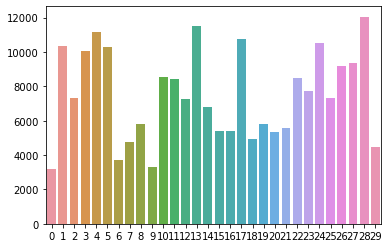

In [111]:
df_labels = pd.DataFrame(pd_km_labels)
label_count = df_labels[0].value_counts()

x = label_count.index
y = label_count.values

sns.barplot(x, y)

In [53]:
def location(index):
    example = int(index/144)
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    head = layer_head_location % 12
    return (example, layer, head)

In [26]:
def layer(index):
    layer_head_location = index % 144
    return int(layer_head_location/12)
    
def head(index):
    layer_head_location = index % 144
    layer = int(layer_head_location/12)
    return layer_head_location % 12

In [68]:
location(12)

(0, 1, 0)

In [112]:
df_labels_indexed = df_labels

In [113]:
df_labels_indexed.rename(columns={0:'cluster'},inplace=True)

In [115]:
df_labels_indexed['layer'] = (df_labels_indexed.index.to_series().apply(layer))
df_labels_indexed['head'] = (df_labels_indexed.index.to_series().apply(head))

In [29]:
def index_layer_heads(df):
    df.rename(columns={0:'cluster'},inplace=True)
    df['layer'] = (df.index.to_series().apply(layer))
    df['head'] = (df.index.to_series().apply(head))
    return df

# def index_layer_heads(df):
#     df.rename(columns={0:'cluster'},inplace=True)
#     df.assign(layer=(df.index.to_series().apply(layer)))
#     df.assign(head=(df.index.to_series().apply(head)))
#     return df

In [11]:
df_labels_indexed.head()

NameError: name 'df_labels_indexed' is not defined

In [8]:
gdf = dask_cudf.read_csv(os.path.join('file://../../representations/final/', 'partitions/*.csv'))

In [9]:
%%time
n_clusters = 30
random_state = 0

kmeans_cuml = daskKMeans(
                       client=client,
                       init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=400,
                       random_state=random_state)

trained_kmeans = kmeans_cuml.fit(gdf)

CPU times: user 57.8 s, sys: 7.08 s, total: 1min 4s
Wall time: 19min 17s


In [10]:
#60_00.csv - 60_13.csv 7-21-20 00:31
torch.save(trained_kmeans, os.path.join(data_dir,'dask_kmeans_model_med_7_20.bin'))

In [14]:
pd_labels = get_pd_labels(trained_kmeans, gdf) #returns a pandas series

TypeError: rename() got an unexpected keyword argument 'columns'

In [18]:
df_labels = pd.DataFrame(pd_labels)

In [30]:
df_labels = index_layer_heads(df_labels)

In [32]:
df_labels.head(20)

,cluster,layer,head
0,11,0,0
1,19,0,1
2,14,0,2
3,14,0,3
4,15,0,4
5,15,0,5
6,15,0,6
7,15,0,7
8,29,0,8
9,15,0,9


In [33]:
torch.save(df_labels, os.path.join(data_dir,'dask_kmeans_df_labels_7_20.bin'))

In [39]:
cluster_layer = df_labels.groupby(['cluster','layer']).count()

In [40]:
cluster_layer.head(30)

head
cluster layer      
0       0      1712
        1      1669
        2      1586
        3      2021
        4      2015
        5      2001
        6      1608
        7      1674
        8      1605
        9      1898
        10     2134
        11     2182
1       0      1697
        1      2416
        2      1976
        3      1628
        4      2118
        5      2374
        6      2613
        7      2816
        8      2793
        9      2430
        10     1899
        11     1933
2       0       694
        1       848
        2      1084
        3      1270
        4       739
        5       853